## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

### Setup

In [7]:
import sklearn
import pandas



ModuleNotFoundError: No module named 'sklearn'

In [6]:
import os
import yaml
import importlib
import pandas as pd
import sklearn
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

os.chdir("../scripts")

import preprocess, train, inference, interpret

ModuleNotFoundError: No module named 'pandas'

In [ ]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

### Load and Prepare the Data

In [ ]:
file_name = "BTC-USD.csv"
data = preprocess.load_data(file_name)
data.head(3)

Date         Open         High          Low        Close  \
0  2017-03-10  1189.359985  1270.469971  1077.250000  1116.719971   
1  2017-03-11  1116.319946  1193.829956  1116.319946  1175.829956   
2  2017-03-12  1176.619995  1226.979980  1175.359985  1221.380005   

     Adj Close     Volume  
0  1116.719971  563795968  
1  1175.829956  283320000  
2  1221.380005  227176000

In [ ]:
importlib.reload(preprocess)
train_df, test_df = preprocess.prep_data(df=data, train_frac=0.5, plot_df=True)

Starting with data preparation...
Completed.


In [ ]:
train_df.shape, test_df.shape

((913, 7), (913, 7))

### Explore the Data

In [ ]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df['Close_Change'] = plot_df.Close.pct_change(1)
plot_df = plot_df.dropna()

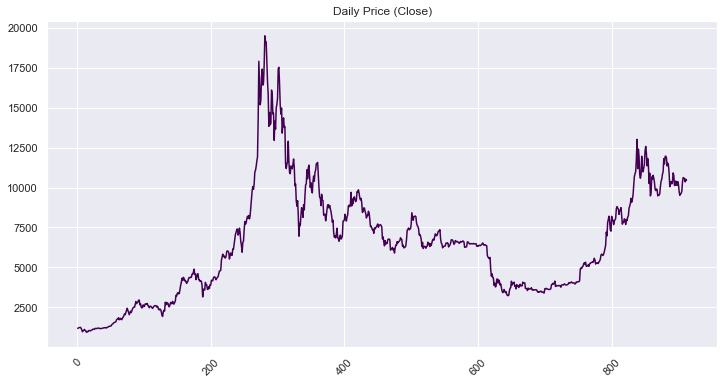

In [ ]:
plot_df['Close'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Daily Price (Close)')
plt.show()

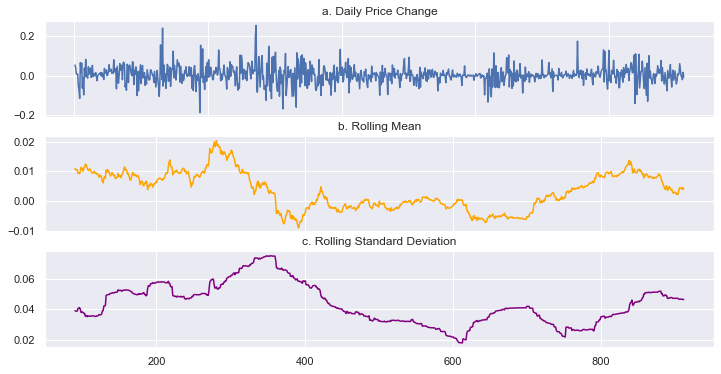

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Close_Change'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
plot_df['Close_Change'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Close_Change'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [ ]:
sequence_length = 30
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
label_name = 'Close'

In [ ]:
importlib.reload(train)
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

Starting with model training...
tensor([[[9.6552e-03, 8.4716e-03, 4.9471e-01,  ..., 6.6667e-01,
          1.8182e-01, 0.0000e+00],
         [1.2840e-02, 2.2280e-03, 1.8349e-01,  ..., 8.3333e-01,
          1.8182e-01, 0.0000e+00],
         [1.5294e-02, 9.7824e-04, 1.1125e-01,  ..., 1.0000e+00,
          1.8182e-01, 0.0000e+00],
         ...,
         [1.3209e-02, 7.3013e-03, 1.4423e-01,  ..., 5.0000e-01,
          2.7273e-01, 3.3333e-01],
         [1.2898e-02, 2.9783e-03, 4.3347e-02,  ..., 6.6667e-01,
          2.7273e-01, 3.3333e-01],
         [1.2847e-02, 5.8058e-04, 4.1463e-02,  ..., 8.3333e-01,
          2.7273e-01, 3.3333e-01]],

        [[1.2840e-02, 2.2280e-03, 1.8349e-01,  ..., 8.3333e-01,
          1.8182e-01, 0.0000e+00],
         [1.5294e-02, 9.7824e-04, 1.1125e-01,  ..., 1.0000e+00,
          1.8182e-01, 0.0000e+00],
         [1.5862e-02, 4.3864e-03, 3.4230e-02,  ..., 0.0000e+00,
          1.8182e-01, 0.0000e+00],
         ...,
         [1.2898e-02, 2.9783e-03, 4.3347e-02,  

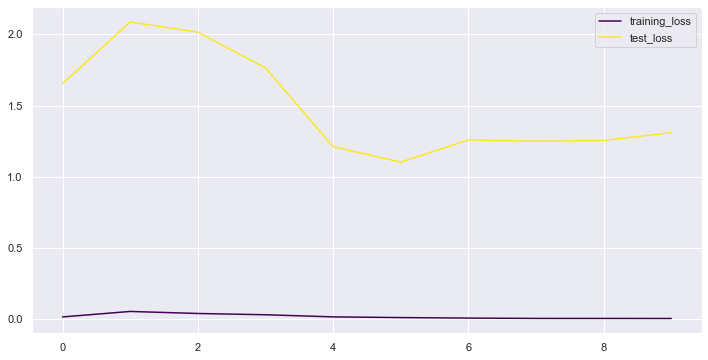

In [ ]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [ ]:
importlib.reload(inference)
predictions_descaled, labels_descaled, predictions = inference.predict(df=test_df,
                                                          label_name='Close',
                                                          sequence_length=sequence_length)

predictions_descaled.shape, predictions_descaled.shape
predictions_descaled[-1], predictions[-1]

(18161.7179678243, 0.9280338883399963)

In [ ]:
importlib.reload(inference)
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

Error on all test data:
{"RMSE":19400.35,"MAE":14268.66}


Error on partial test data:
{"RMSE":2615.98,"MAE":2446.5}


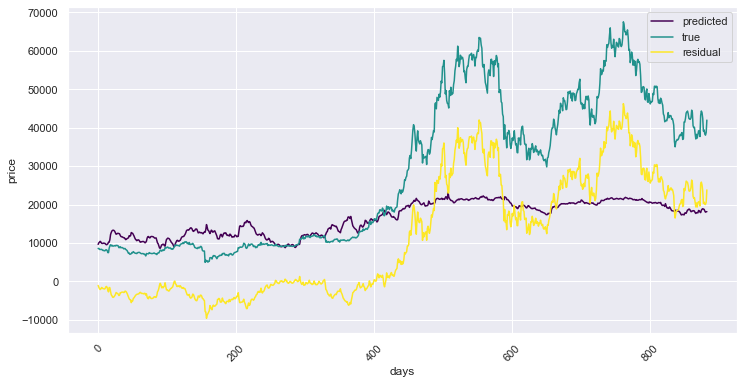

In [ ]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()

### Find important features

In [ ]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [ ]:
background_data_size = 5
test_sample_size = 5
sequence_length = 30

Background: tensor([[[9.6552e-03, 8.4716e-03, 4.9471e-01, 4.1693e-01, 6.6667e-01,
          1.8182e-01, 0.0000e+00],
         [1.2840e-02, 2.2280e-03, 1.8349e-01, 4.5697e-01, 8.3333e-01,
          1.8182e-01, 0.0000e+00],
         [1.5294e-02, 9.7824e-04, 1.1125e-01, 4.4358e-01, 1.0000e+00,
          1.8182e-01, 0.0000e+00],
         [1.5862e-02, 4.3864e-03, 3.4230e-02, 4.3843e-01, 0.0000e+00,
          1.8182e-01, 0.0000e+00],
         [1.6298e-02, 1.3818e-03, 4.2784e-02, 4.3587e-01, 1.6667e-01,
          1.8182e-01, 0.0000e+00],
         [1.6815e-02, 2.5505e-03, 1.3998e-02, 4.8434e-01, 3.3333e-01,
          1.8182e-01, 0.0000e+00],
         [1.3486e-02, 1.0136e-02, 2.4618e-01, 1.8057e-01, 5.0000e-01,
          1.8182e-01, 0.0000e+00],
         [8.7668e-03, 1.1650e-02, 1.9441e-01, 4.1178e-01, 6.6667e-01,
          1.8182e-01, 0.0000e+00],
         [1.9557e-03, 9.7517e-03, 4.4932e-01, 5.4706e-01, 8.3333e-01,
          1.8182e-01, 0.0000e+00],
         [5.3459e-03, 4.9734e-03, 2.5700e-0

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.


[[-1.9140085e-02  1.8639354e-03  9.2126272e-04  1.8594104e-03
   8.9690619e-04  1.5169922e-03  2.3833644e-03]
 [ 2.5881983e-03  8.5566269e-04  7.8180415e-04  3.5963780e-03
   1.6175803e-03  2.3794801e-03  1.1081065e-03]
 [ 6.5001770e-04  1.3217691e-03  1.6931619e-03  5.1758479e-04
   2.3164381e-03  1.3097881e-03  1.2024277e-03]
 [ 1.7697101e-03  2.5995376e-03  2.8609626e-03 -4.4930103e-04
   8.3739759e-04  1.7539760e-03  1.3147902e-03]
 [ 2.6390390e-03  2.4699215e-03  2.4069301e-03  4.8730690e-03
   1.4951563e-03  2.1032873e-03  7.9950166e-04]
 [ 2.1291357e-03  1.6864717e-03  8.2077133e-04  2.3919030e-03
   1.0775768e-03  9.5314410e-04  1.3212119e-03]
 [ 3.1066169e-03  2.9961583e-03  1.9410427e-03  3.7745242e-03
   7.8279030e-04  2.5386058e-03  1.5975902e-03]
 [ 2.1857198e-03  2.3143752e-03  1.7409861e-03  1.2213226e-03
   4.3029245e-04  1.3349578e-03  1.7669026e-03]
 [ 1.0232745e-03  9.7323628e-04  1.3836322e-03  1.6404878e-03
   2.2066464e-03  2.7716183e-03  1.4224148e-03]
 [ 1.91697

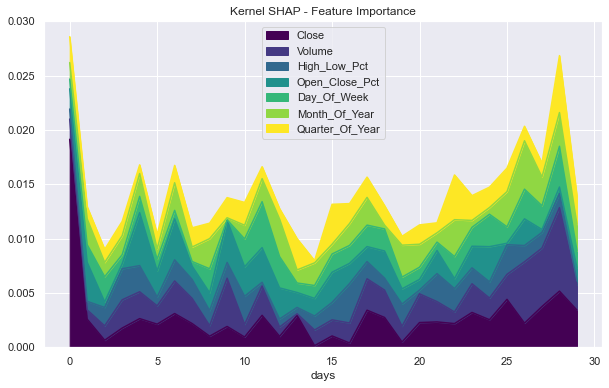

In [ ]:
importlib.reload(train)
importlib.reload(interpret)
import numpy as np

shap_values, explainer = interpret.get_important_features_lime(
    background_data_size,
    test_sample_size,
    sequence_length
)

shap_plot = pd.DataFrame(np.absolute(shap_values), columns=train_df.columns.tolist())
shap_plot['days'] = shap_plot.index
shap_plot.head()
shap_plot.iloc[-1]

shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Kernel SHAP - Feature Importance")
plt.show()

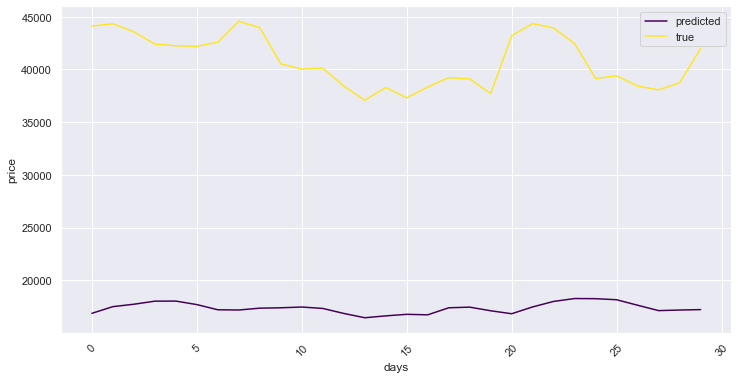

Close              0.009655
Volume             0.008472
High_Low_Pct       0.494707
Open_Close_Pct     0.416934
Day_Of_Week        0.666667
Month_Of_Year      0.181818
Quarter_Of_Year    0.000000
Name: 0, dtype: float64
[0.00275794 0.0048882  0.00096062 0.00124037 0.00132969 0.0014558
 0.00185642]


In [ ]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled[-30:]
df_pred['true'] = labels_descaled[-30:]
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()


# Yesterday
index = -1
print(train_df.loc[0])
print(shap_values[index])
shap.force_plot(predictions_descaled[-1], shap_values[index], train_df.loc[0], show=True)

In [ ]:
index=0
shap.initjs()
print(shap_values[0]) ## -30 Days

shap_values_reverse = shap_values
print(shap_values[-1])
print(data.iloc[-1])
shap.force_plot(predictions_descaled[-1], shap_values[index], train_df.loc[index], show=True)

[-0.00626366  0.00140782  0.00097928  0.00112989  0.00120426  0.00132249
  0.00133352]
[0.00275794 0.0048882  0.00096062 0.00124037 0.00132969 0.0014558
 0.00185642]
Date          2022-03-10
Open             41909.1
High             41999.5
Low              38846.3
Close            39238.9
Adj Close        39238.9
Volume       30942173184
Name: 1826, dtype: object


In [ ]:
data.shape

(1827, 7)

In [ ]:
importlib.reload(train)
importlib.reload(interpret)

shap_values, explainer = interpret.get_important_features_shapley(
    background_data_size,
    test_sample_size,
    sequence_length
)

X:  [[9.65523201e-03 8.47158866e-03 4.94706993e-01 ... 6.66666667e-01
  1.81818182e-01 0.00000000e+00]
 [1.28400578e-02 2.22803689e-03 1.83486017e-01 ... 8.33333333e-01
  1.81818182e-01 0.00000000e+00]
 [1.52942788e-02 9.78240078e-04 1.11251166e-01 ... 1.00000000e+00
  1.81818182e-01 0.00000000e+00]
 ...
 [5.07319149e-01 4.30816247e-01 1.53732456e-01 ... 6.66666667e-01
  7.27272727e-01 6.66666667e-01]
 [5.16152835e-01 3.36671707e-01 4.42959357e-02 ... 8.33333333e-01
  7.27272727e-01 6.66666667e-01]
 [5.12059138e-01 3.00235647e-01 3.76521117e-02 ... 1.00000000e+00
  7.27272727e-01 6.66666667e-01]]
Y:  [0.00965523 0.01284006 0.01529428 0.01586217 0.01629752 0.0168153
 0.01348554 0.00876676 0.00195572 0.00534594 0.00628829 0.00986106
 0.00601405 0.00544561 0.         0.00189974 0.00157355 0.00583247
 0.00590683 0.00551997 0.00479044 0.00723442 0.00770371 0.00887129
 0.01111484 0.01054586 0.01008951 0.01320914 0.01289771 0.01284652
 0.01348877 0.0134489  0.01441227 0.01416227 0.01248715 0.

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


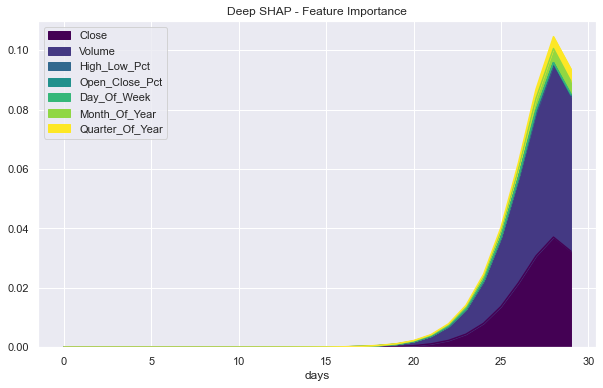

In [ ]:
import numpy as np
shap_plot = np.absolute(pd.read_csv(Path("../data/shap_values_deeplift_2020-09-20_2020-10-20.csv")))
shap_plot.head()
shap_plot['days'] = shap_plot.index
# shap_plot.head()

shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()

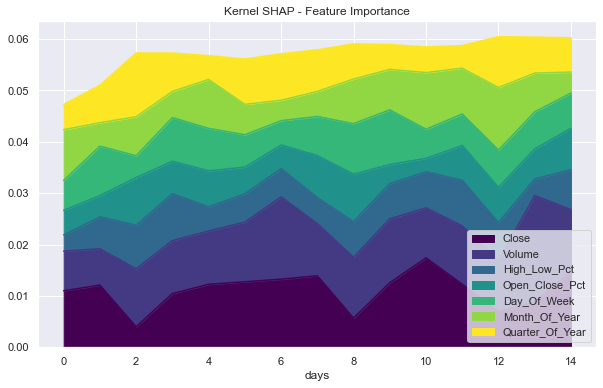

In [ ]:
import numpy as np
shap_plot = np.absolute(pd.read_csv(Path("../data/shap_values_is_lime_2020-12-01_2020-12-16.csv")))
shap_plot.head()
shap_plot['days'] = shap_plot.index
# shap_plot.head()

shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Kernel SHAP - Feature Importance")
plt.show()

In [ ]:
importlib.reload(inference)

    
print(inference.descale_value(1))

19497.400391


In [ ]:
df = preprocess.load_data("clean_data.csv")
df  = df[
        ["Date", "Close", "Volume", "High_Low_Pct", "Open_Close_Pct", "Day_Of_Week", "Month_Of_Year", "Quarter_Of_Year"]
    ]

preprocess.save_data(df, "clean_data.csv")


2
3
4
5
5
